## Import modules

In [31]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

from keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input


warnings.filterwarnings('ignore')
%matplotlib inline

## Load the dataset

In [32]:
BASE_DIR = 'UTKFace/'

# labels of images: age, gender, ethnicity, time
image_paths = []
age_labels = []
gender_labels = []

for filename in os.listdir(BASE_DIR):

    image_path = os.path.join(BASE_DIR, filename)
    age, gender = map(int, filename.split('_')[:2])

    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)


## Convert to Dataframe

In [33]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()


,image,age,gender
0,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg,9,1
1,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg,36,0
2,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg,86,1
3,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg,26,1
4,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg,1,1


## Data analysis

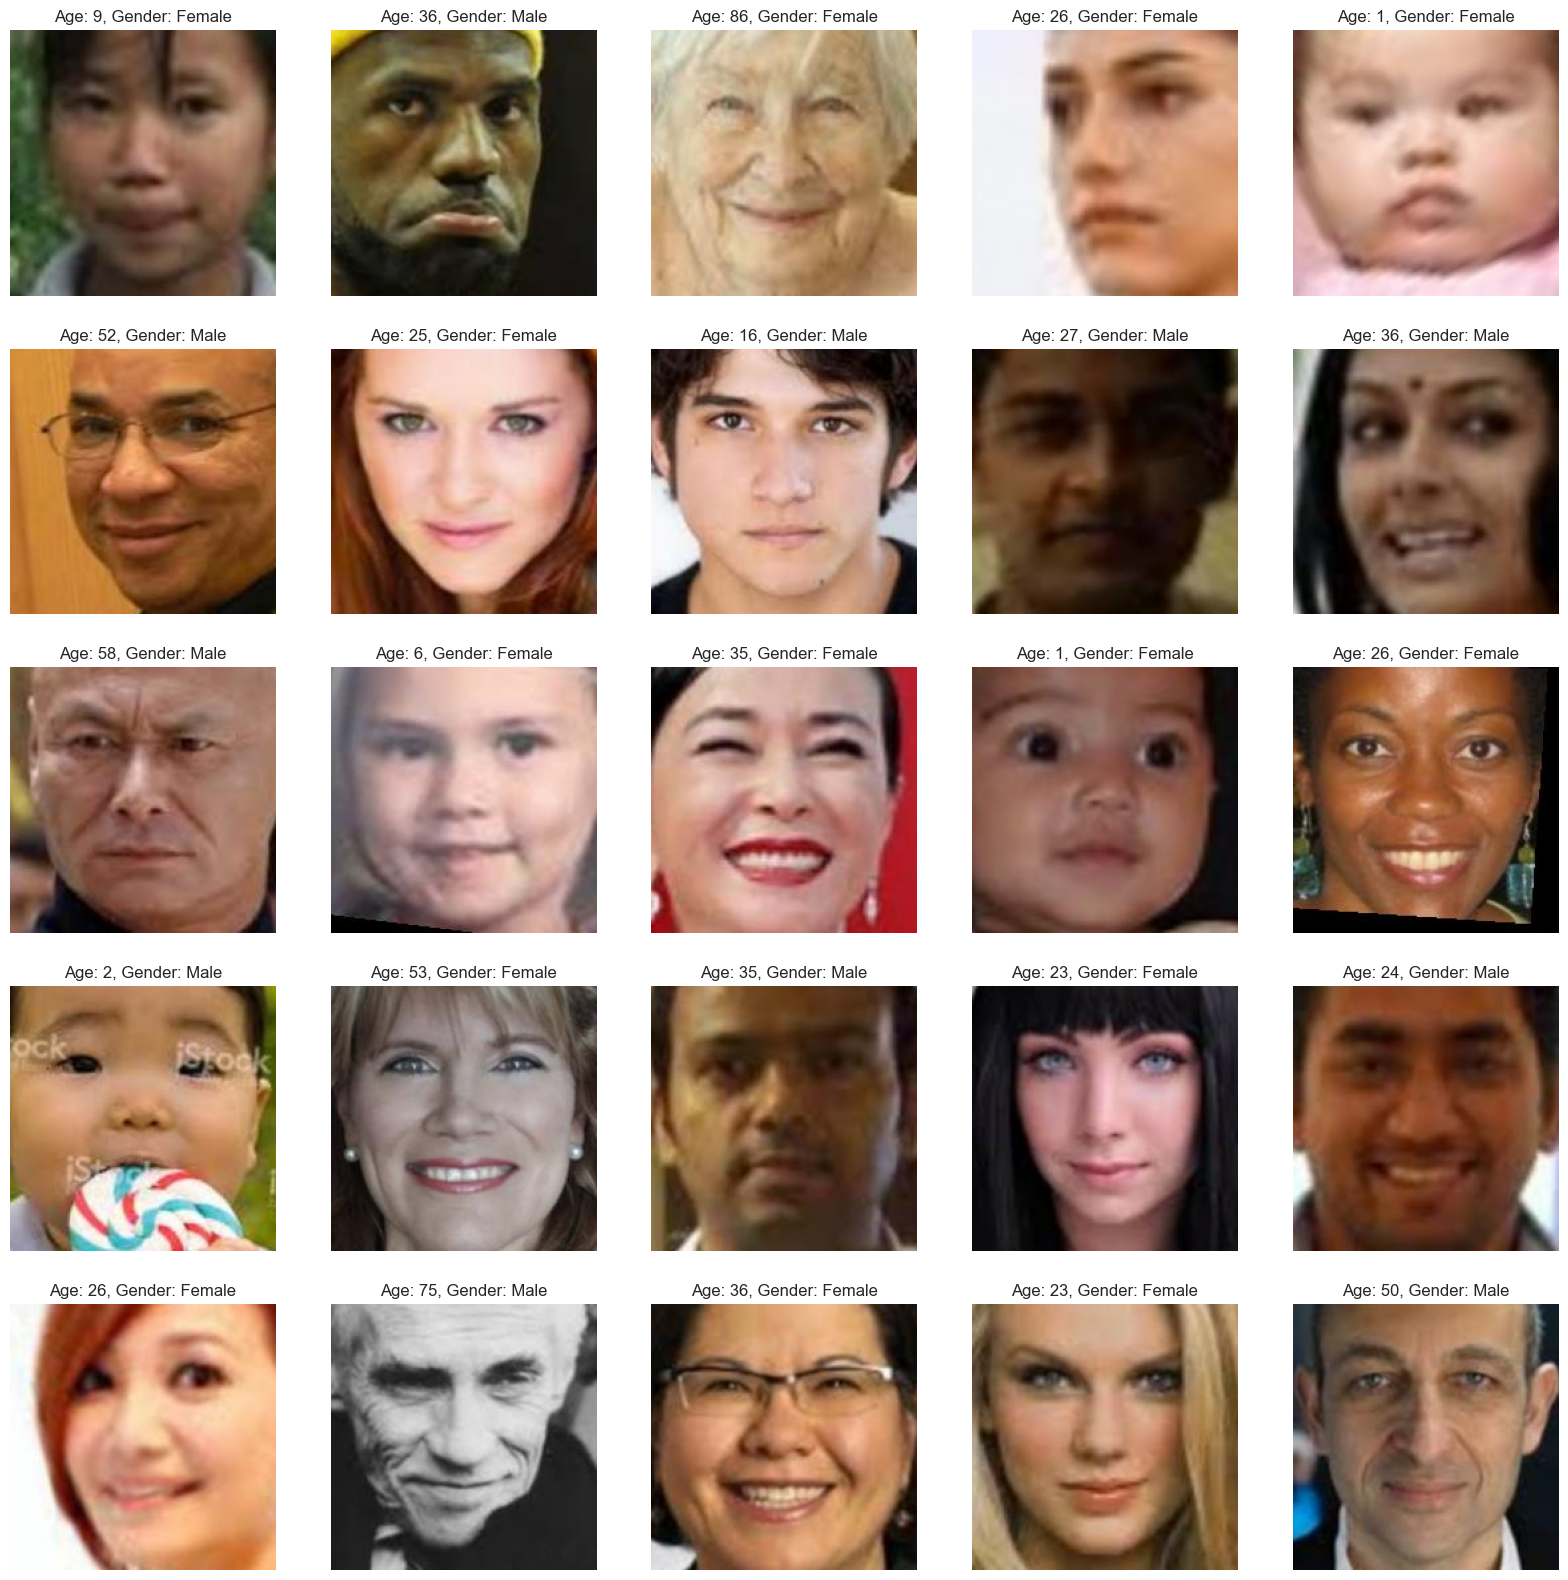

In [34]:
# map labels for gender
gender_dict = {0: 'Male', 1: 'Female'}

plt.figure(figsize=(20, 20))
files = df.iloc[:25]
for i, file, age, gender in files.itertuples():
    plt.subplot(5, 5, i+1)
    img = np.array(load_img(file))
    plt.imshow(img)
    plt.title(f'Age: {age}, Gender: {gender_dict[gender]}')
    plt.axis('off')

<Axes: xlabel='age', ylabel='Density'>

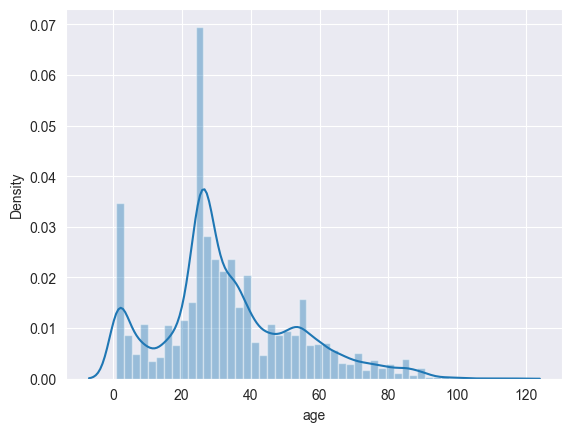

In [35]:
sns.distplot(df['age'])

<Axes: xlabel='gender', ylabel='Count'>

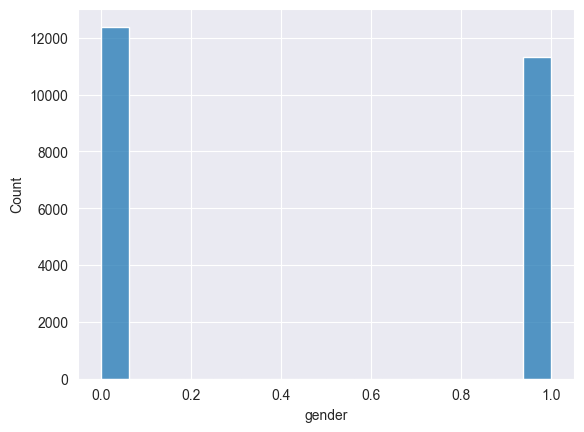

In [36]:
sns.histplot(df['gender'])

In [37]:
from PIL import Image
from tqdm import tqdm  # for progress bar


def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 3)
    return features

In [38]:
X = extract_features(df['image'])

100%|██████████| 23708/23708 [00:43<00:00, 544.31it/s]


In [39]:
# normalize images
X = X / 255

In [40]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
input_shape = (128, 128, 3)

## Model creation

In [73]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)
dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)
output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [74]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_61 (Conv2D)             (None, 126, 126, 32  896         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_35 (MaxPooling2D  (None, 63, 63, 32)  0           ['conv2d_61[0][0]']              
 )                                                                                         

In [75]:
# train and save models
from pathlib import Path

path = Path("models")
path.mkdir(exist_ok=True)
cpt_filename = "{epoch:02d}_checkpoint.hdf5"
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, verbose=1)
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/30
593/593 [==============================] - ETA: 0s - loss: 15.9023 - gender_out_loss: 0.6891 - age_out_loss: 15.2132 - gender_out_accuracy: 0.5355 - age_out_accuracy: 0.0468
Epoch 1: saving model to models/01_checkpoint.hdf5
593/593 [==============================] - 178s 296ms/step - loss: 15.9023 - gender_out_loss: 0.6891 - age_out_loss: 15.2132 - gender_out_accuracy: 0.5355 - age_out_accuracy: 0.0468 - val_loss: 13.6917 - val_gender_out_loss: 0.6041 - val_age_out_loss: 13.0876 - val_gender_out_accuracy: 0.6733 - val_age_out_accuracy: 0.0493
Epoch 2/30
593/593 [==============================] - ETA: 0s - loss: 11.8260 - gender_out_loss: 0.5247 - age_out_loss: 11.3013 - gender_out_accuracy: 0.7425 - age_out_accuracy: 0.0315
Epoch 2: saving model to models/02_checkpoint.hdf5
593/593 [==============================] - 163s 274ms/step - loss: 11.8260 - gender_out_loss: 0.5247 - age_out_loss: 11.3013 - gender_out_accuracy: 0.7425 - age_out_accuracy: 0.0315 - val_loss: 10.2749 -

## Plot the results

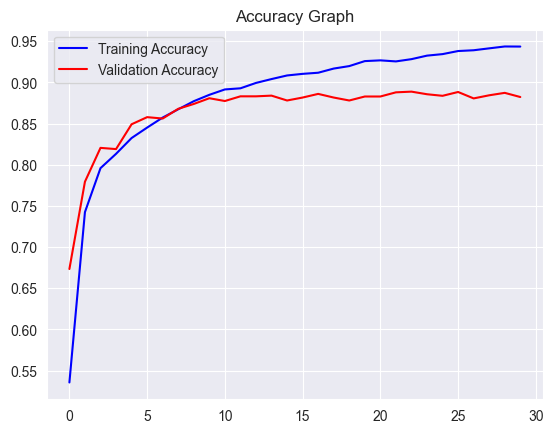

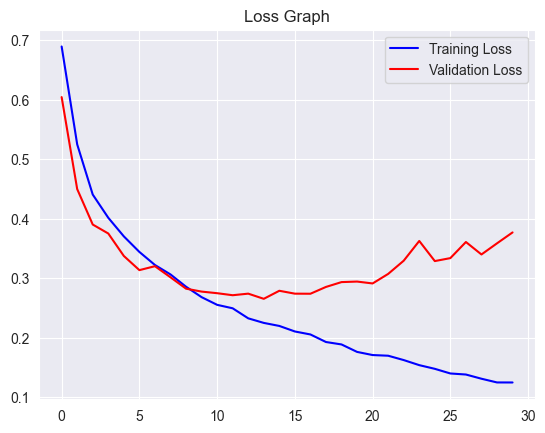

In [77]:
# for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

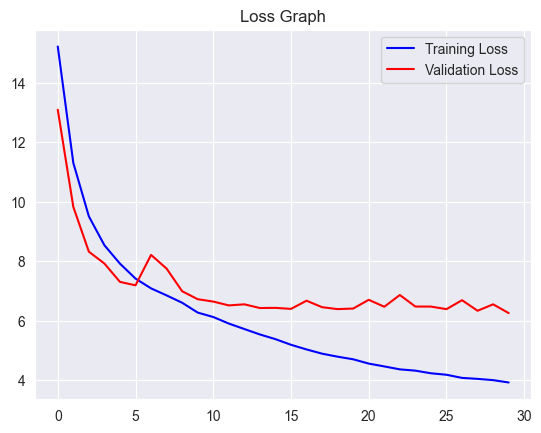

In [78]:
# for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Conclusion

**The model showed itself best at the 10th epoch of training. It is not overtrained and has better accuracy. This is what I would use in production.**

## Prediction with Test Data

Original Gender: Female Original Age: 32
1/1 [==============================] - 0s 24ms/step
Predicted Gender: Female Predicted Age: 28


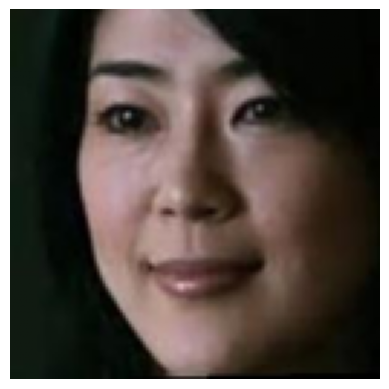

In [85]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128, 3))

Original Gender: Male Original Age: 25
1/1 [==============================] - 0s 35ms/step
Predicted Gender: Male Predicted Age: 26


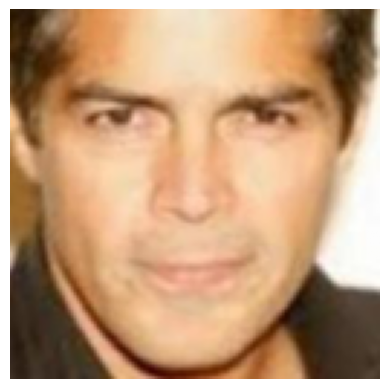

In [87]:
image_index = 777
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128, 3))


Original Gender: Male Original Age: 44
1/1 [==============================] - 0s 27ms/step
Predicted Gender: Male Predicted Age: 43


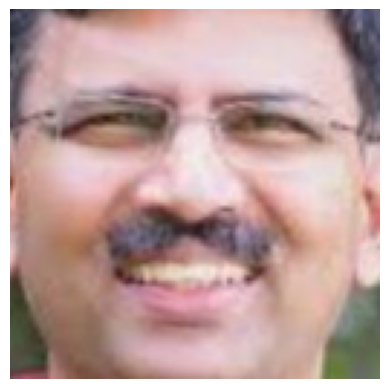

In [93]:
image_index = 21120
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128, 3))


Original Gender: Female Original Age: 80
1/1 [==============================] - 0s 34ms/step
Predicted Gender: Female Predicted Age: 81


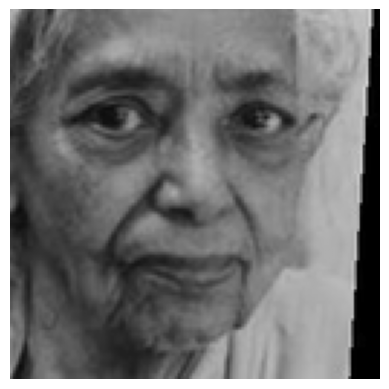

In [131]:

from random import randint

image_index = randint(1, 23000)
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128, 3))